# 직접 해보기

## 모듈화한 코드

In [ ]:
import numpy as np
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
# vocab 클래스
class AlphabetVocab():
    def __init__(self):
        self.__idx2char = 'SEPabcdefghijklmnopqrstuvwxyz'
        self.__char2idx = {c: i for i, c in enumerate(self.__idx2char)}

    def encode(self, word):
        return [self.__char2idx[c] for c in word]

    def decode(self, idx):
        return ''.join([self.__idx2char[i] for i in idx])
    
    def __len__(self):
        return len(self.__idx2char)
    
    def idx2char(self, idx):
        return self.__idx2char[idx]
    
    def char2idx(self, char):
        return self.__char2idx[char]

In [ ]:
# feature, label 나누기, max_len 구하기
def data_to_Xy(datas):
    X, y = [], []
    for data in datas:
        X.append(data[0])
        y.append(data[1])
    _X = X + y
    _y = y + X
    max_len = max([len(x) for x in _X])
    return (_X, _y), max_len

In [ ]:
# 데이터셋 클래스
class ConverseWordDataset(Dataset):
    def __init__(self, X, y=None, max_len=10, vocab=None):
        super().__init__()
        # 최대 길이
        self.max_len = max_len
        # vocab 저장
        self.vocab = vocab
        # one hot encoding vector
        self.oh_vector = np.eye(len(self.vocab))
        # 데이터를 토큰화
        self.X = self.__tokenizer(X)
        # y가 있으면 토큰화
        if y is not None:
            _y = self.__tokenizer(y)
            # 디코더의 입력값과 출력값을 구분하기 위해 시작 토큰과 끝 토큰을 추가
            self.y_dec = self.__add_se_token(_y)
            self.y_target = self.__add_se_token(_y, sep_tok='E')
        else:
            # y가 없으면 디코더의 입력값만 생성
            self.y_dec = self.__get_eval_dec_input()
            self.y_target = None
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        # 인코더의 입력값을 ohe
        feature = self.oh_vector[self.X[idx]]
        # tensor로 변환
        feature = torch.tensor(feature, dtype=torch.float)
        if self.y_target is not None:
            # 디코더의 입력값과 출력값(SE토근이 추가된 y)을 ohe
            dec_input = self.oh_vector[self.y_dec[idx]]
            target = self.oh_vector[self.y_target[idx]]
            # tensor로 변환
            dec_input = torch.tensor(dec_input, dtype=torch.float)
            target = torch.tensor(target, dtype=torch.float)
            return feature, dec_input, target
        else:
            # 디코더의 입력값만 ohe (SPPPP...)
            dec_input = self.oh_vector[self.y_dec[idx]]
            # tensor로 변환
            dec_input = torch.tensor(dec_input, dtype=torch.float)
            return feature, dec_input, None
    
    def __tokenizer(self, datas):
        token_datas = []
        for data in datas:
            # 패딩
            padding_data = data + 'P' * (self.max_len - len(data))
            # 토큰화
            token_data = self.vocab.encode(padding_data)
            token_datas.append(token_data)
        # 토큰화된 데이터를 numpy 배열로 변환
        return np.array(token_datas)
    
    def __add_se_token(self, token_datas, sep_tok='S'):
        add_sep_datas = []
        for token_data in token_datas:
            if sep_tok == 'S':
                add_sep_data = [self.vocab.char2idx(sep_tok)] + list(token_data)
            elif sep_tok == 'E':
                add_sep_data = list(token_data) + [self.vocab.char2idx(sep_tok)]
            add_sep_datas.append(add_sep_data)
        return np.array(add_sep_datas)
    
    def __get_eval_dec_input(self):
        # 데이터의 총 갯수
        data_len = len(self.X)
        # max길이의 S로 시작해 P가 이어지는 데이터 생성 * 데이터의 총 갯수
        eval_dec_input = [[self.vocab.char2idx('S')] + [self.vocab.char2idx('P')] * (self.max_len) for _ in range(data_len)]
        return np.array(eval_dec_input)

In [ ]:
######################
# 모델 정의
######################
class ConvWordS2SModel(nn.Module):
    def __init__(self, enc_input_size, dec_input_size, hidden_size, output_size, n_layers=1, bidirectional=False):
        super().__init__()
        self.enc_input_size = enc_input_size
        self.hidden_size = hidden_size
        self.shape_size = (2 if bidirectional else 1) * n_layers
        
        self.encoding_layer = nn.RNN(
                                    input_size=enc_input_size,
                                    hidden_size=hidden_size,
                                    num_layers=n_layers,
                                    batch_first=True,
                                    bidirectional=bidirectional,
                                    )
        self.decoding_layer = nn.RNN(
                                    input_size=dec_input_size,
                                    hidden_size=hidden_size,
                                    num_layers=n_layers,
                                    batch_first=True,
                                    bidirectional=bidirectional,
                                    )
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_size*2, output_size),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, enc_input, dec_input):
        shape = (self.shape_size, enc_input.size(0), self.hidden_size)
        hidden_state = torch.zeros(shape).to(enc_input.device)
        # 인코더의 입력값을 넣어 인코딩
        _, enc_hidden = self.encoding_layer(enc_input, hidden_state)
        # 인코더의 히든 벡터를 디코더의 히든 벡터로 사용
        dec_output, _ = self.decoding_layer(dec_input, enc_hidden)
        # 디코더의 출력값을 예측값으로 변환
        output = self.output_layer(dec_output)
        return output

In [ ]:
######################
# 트레인 루프 정의
######################
def train(model, loader, optimizer, device, loss_fn):
    # 모델을 학습 모드로 설정
    model.train()
    # loss를 저장할 변수
    loss_score = None
    # score를 저장할 변수
    acc_score = None
    # 학습 루프
    for feature, dec_input, target in loader:
        # device에 데이터 이동
        feature = feature.to(device)
        dec_input = dec_input.to(device)
        target = target.to(device)
        # 모델에 feature와 dec_input을 넣어 예측값 생성
        output = model(feature, dec_input)
        # loss 계산
        loss = loss_fn(output, target)
        # loss 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # loss 기록
        loss_score = loss.item()
        target = target.detach().cpu().numpy().argmax(axis=-1)
        output = output.detach().cpu().numpy().argmax(axis=-1)
        # print(target.shape, output.shape)
        # score 계산
        score = accuracy_score(target.argmax(axis=1), output.argmax(axis=1))
        # score 기록
        acc_score = score
    # loss와 score를 반환
    return loss_score, acc_score
######################
# 테스트 루프 정의
######################
@torch.inference_mode()
def test(model, loader, device):
    # 모델을 평가 모드로 설정
    model.eval()
    # 예측값을 저장할 변수
    pred = None
    # 평가 루프
    for feature, dec_input, _ in loader:
        # device에 데이터 이동
        feature = feature.to(device)
        dec_input = dec_input.to(device)
        # 모델에 feature와 dec_input을 넣어 예측값 생성
        output = model(feature, dec_input)
        # 예측값을 pred_list에 추가
        pred = output.detach().cpu().numpy()
    return pred

## 데이터

In [1]:
seq_data = [
    ['man', 'women'], ['black', 'white'], ['king', 'queen'],
    ['girl', 'boy'], ['up', 'down'], ['high', 'low'],
    ['long', 'short'], ['hot', 'cold'], ['rich', 'poor'],
    ['sick', 'healthy'], ['thick', 'thin'], ['fat', 'slim'], 
    ['strong', 'weak'], ['happy', 'sad'], ['right', 'wrong'],
    ['win', 'lose'], ['pass', 'fail'], ['true', 'false'],
    ['love', 'hate'], ['beautiful', 'ugly'], ['kind', 'cruel'],
    ['peace', 'war'], ['safe', 'dangerous'], ['clean', 'dirty'],
    ['soft', 'hard'], ['wrong', 'right'], ['new', 'old'],
    ['good', 'bad'], ['big', 'small'], ['tall', 'short'],
    ['fast', 'slow'], ['hot', 'cold'], ['young', 'old'],
    ['easy', 'difficult'], ['light', 'dark'], ['quiet', 'noisy'],
]

#####################
# 데이터 나누기 함수 정의
#####################
# feature, label 나누기, max_len 구하기
def data_to_Xy(datas):
    X, y = [], []
    for data in datas:
        X.append(data[0])
        y.append(data[1])
    _X = X + y
    _y = y + X
    max_len = max([len(x) for x in _X])
    return (_X, _y), max_len

## 모델 생성및 테스트

In [6]:
######################
# 모듈 임포트
######################
from modules.Seq2Seq_test import *

######################
# 데이터셋, 로더 정의
######################
# 단어 사전 생성
vocab = AlphabetVocab()
# 데이터 분리
(X, y), max_len = data_to_Xy(seq_data)
# 데이터셋 생성
convword_dataset = ConverseWordDataset(X=X, y=y, max_len=max_len, vocab=vocab)

######################
# 상수 정의
######################
# vocab 크기
VOCAB_SIZE = len(vocab)
# EMDEDDING 크기
EMBEDDING_SIZE = 64
# 은닉층 크기
HIDDEN_SIZE = 128
# 레이어 수
N_LAYERS = 4
# 양방향 여부
BIDIR = True
# 학습률
LR = 0.001
# 에폭
N_EPOCHS = 1000
# 디바이스
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
CPU = 'cpu'

######################
# 모델 생성, 기타 객체 생성
######################
model = ConvWordModel(vocab_size=VOCAB_SIZE,
                    embedding_size=EMBEDDING_SIZE,
                    hidden_size=HIDDEN_SIZE,
                    n_layers=N_LAYERS,
                    bidirectional=BIDIR,
                    ).to(DEVICE)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

model

ConvWordModel(
  (embedding_layer): ConvWordEmbedding(
    (embedding): Embedding(29, 64)
  )
  (seq2seq_layer): ConvWordSeq2Seq(
    (encoding_layer): RNN(64, 128, num_layers=4, batch_first=True, bidirectional=True)
    (decoding_layer): RNN(64, 128, num_layers=4, batch_first=True, bidirectional=True)
  )
  (output_layer): ConvWordOutput(
    (output_layer): Sequential(
      (0): Linear(in_features=256, out_features=29, bias=True)
      (1): Softmax(dim=-1)
    )
  )
)

In [7]:
######################
# 모델 학습
######################
# 프로그래스바 설정
progress_epochs = tqdm(range(N_EPOCHS))
# loss와 acc를 저장할 리스트
loss_list, acc_list = [], []
# 에폭만큼 학습
for epoch in progress_epochs:
    # 트레인 로더 생성
    train_loader = DataLoader(convword_dataset, batch_size=len(convword_dataset), shuffle=True)
    # 트레인
    loss_score, acc_score = train(model, train_loader, optimizer, DEVICE, loss_fn)
    loss_list.append(loss_score)
    acc_list.append(acc_score)

100%|██████████| 1000/1000 [00:05<00:00, 176.52it/s]


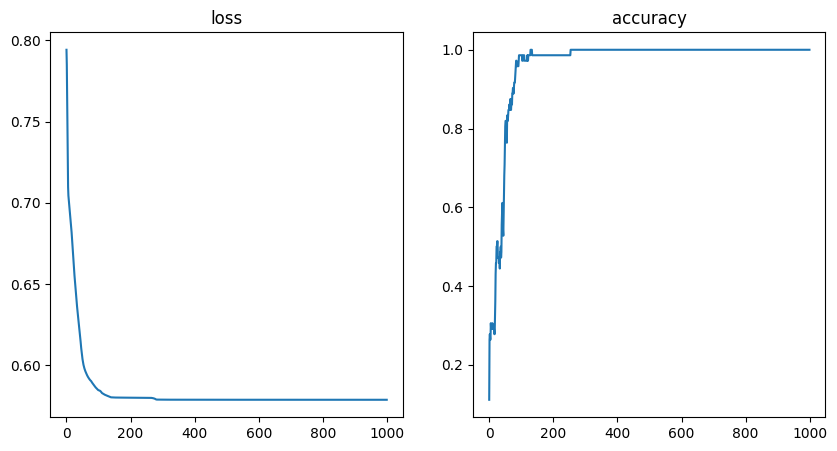

In [8]:
######################
# 학습 결과 시각화
######################
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(loss_list)
axes[0].set_title('loss')
axes[1].plot(acc_list)
axes[1].set_title('accuracy')
plt.show()

In [10]:
######################
# 테스트
######################
# 테스트 데이터 로더 생성
test_loader = DataLoader(convword_dataset, batch_size=len(convword_dataset), shuffle=False)
# 테스트
pred = test(model, test_loader, DEVICE)
# 예측값을 문자열로 변환
for data, pred_y in zip(convword_dataset, pred):
    # feature, dec_input, target = data
    feature, dec_input, target = data
    # nparray로 변환
    feature = feature.numpy()
    target = target.numpy().argmax(axis=-1)[:-1]
    pred_y = pred_y.argmax(axis=-1)[:-1]
    # feature, target, pred_y를 문자열로 변환
    feature = ''.join([vocab.idx2char(i) if i != 2 else '' for i in feature])
    target = ''.join([vocab.idx2char(i) if i != 2 else '' for i in target])
    pred_y = ''.join([vocab.idx2char(i) if i != 2 else '' for i in pred_y])
    is_correct = 'O' if target == pred_y else 'X'
    print(f'{feature}      \t: {target}    \t -> {pred_y}  \t{is_correct}')

man      	: women    	 -> women  	O
black      	: white    	 -> white  	O
king      	: queen    	 -> queen  	O
girl      	: boy    	 -> boy  	O
up      	: down    	 -> down  	O
high      	: low    	 -> low  	O
long      	: short    	 -> short  	O
hot      	: cold    	 -> cold  	O
rich      	: poor    	 -> poor  	O
sick      	: healthy    	 -> healthy  	O
thick      	: thin    	 -> thin  	O
fat      	: slim    	 -> slim  	O
strong      	: weak    	 -> weak  	O
happy      	: sad    	 -> sad  	O
right      	: wrong    	 -> wrong  	O
win      	: lose    	 -> lose  	O
pass      	: fail    	 -> fail  	O
true      	: false    	 -> false  	O
love      	: hate    	 -> hate  	O
beautiful      	: ugly    	 -> ugly  	O
kind      	: cruel    	 -> cruel  	O
peace      	: war    	 -> war  	O
safe      	: dangerous    	 -> dangerous  	O
clean      	: dirty    	 -> dirty  	O
soft      	: hard    	 -> hard  	O
wrong      	: right    	 -> right  	O
new      	: old    	 -> old  	O
good      	: bad    	 ->